Score a candidate ms2 peak according to its coverage of the feature's drift and RT

In [281]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import peakutils
import json

In [282]:
db_name = '/home/ubuntu/UPS2_allion/UPS2_allion-features-1-1097.sqlite'
feature_db_name = '/home/ubuntu/UPS2_allion/UPS2_allion.sqlite'
feature_id = 23
ms2_peak_id = 1

In [283]:
# calculate the ms2 frame rate, raw and summed - assuming ms1 and ms2 alternate
converted_db_name = '/home/ubuntu/UPS2_allion/UPS2_allion.sqlite'
db_conn = sqlite3.connect(converted_db_name)
df = pd.read_sql_query("select value from convert_info where item=\'{}\'".format("raw_frame_period_in_msec"), db_conn)
raw_frame_period_in_msec = float(df.loc[0].value)
raw_frame_ids_per_second = 1.0 / (raw_frame_period_in_msec * 10**-3) # a raw frame comes out at this rate; ms1 and ms2 frames alternate, so need to halve this rate to get the ms1 or ms2 raw frame rate
df = pd.read_sql_query("select value from summing_info limit 1", db_conn)
frame_summing_offset = json.loads(df.loc[0].item())["frame_summing_offset"]
frames_to_sum = json.loads(df.loc[0].item())["frames_to_sum"]
summed_frame_period_in_msec = raw_frame_period_in_msec * frame_summing_offset
summed_frame_ids_per_second = 1.0 / (summed_frame_period_in_msec * 10**-3)
db_conn.close()

In [284]:
# load the summary information for this feature
db_conn = sqlite3.connect(feature_db_name)
feature_df = pd.read_sql_query("select * from features where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [285]:
feature_df["rt_secs_start"] = feature_df.start_frame / summed_frame_ids_per_second
feature_df["rt_secs_end"] = feature_df.end_frame / summed_frame_ids_per_second

In [286]:
feature_df.head()

,feature_id,base_frame_id,base_cluster_id,charge_state,start_frame,end_frame,quality_score,summed_intensity,scan_lower,scan_upper,mz_lower,mz_upper,rt_secs_start,rt_secs_end
0,23,5755,1,3,5748,5761,1.0,542463190,98,118,641.041565,643.049683,574.8,576.1


In [287]:
# load the summary information about this ms2 peak
db_conn = sqlite3.connect(db_name)
ms2_peaks_df = pd.read_sql_query("select * from ms2_peaks where feature_id={}".format(feature_id), db_conn)
db_conn.close()

In [288]:
ms2_peaks_df.head()

,feature_id,peak_id,centroid_mz,composite_mzs_min,composite_mzs_max,centroid_scan,intensity,feature_scan_coverage,feature_frame_coverage
0,23,1,588.361,588337,588385,107,8997131,1.038462,0.652632
1,23,2,861.007,860972,861044,108,10594937,1.038462,0.673684
2,23,3,861.508,861471,861543,108,10319433,1.038462,0.631579
3,23,4,775.952,775922,775986,108,8247937,1.038462,0.736842
4,23,5,776.454,776422,776486,108,7359559,1.038462,0.663158


In [289]:
# get the m/z range for the peak's points
mzs_min = int(ms2_peaks_df[ms2_peaks_df.peak_id==ms2_peak_id].composite_mzs_min)
mzs_max = int(ms2_peaks_df[ms2_peaks_df.peak_id==ms2_peak_id].composite_mzs_max)

In [290]:
mzs_min,mzs_max

(588337, 588385)

In [291]:
# get the raw points for this feature
db_conn = sqlite3.connect(db_name)
peak_raw_points_df = pd.read_sql_query("select * from ms2_feature_region_points where feature_id={} and scaled_mz>={} and scaled_mz<={}".format(feature_id,mzs_min,mzs_max), db_conn)
db_conn.close()

In [292]:
peak_raw_points_df.head()

,frame_id,mz,scan,intensity,point_id,scaled_mz,feature_id
0,57553,588,95,240,16618,588345,23
1,57579,588,95,1197,11162,588353,23
2,57655,588,95,391,9229,588357,23
3,57533,588,95,581,16836,588357,23
4,57555,588,95,721,17074,588357,23


In [293]:
raw_frame_ids_per_second, summed_frame_ids_per_second

(50.0, 10.0)

In [294]:
peak_raw_points_df["retention_time_secs"] = (peak_raw_points_df.frame_id / raw_frame_ids_per_second) / 2

In [295]:
peak_raw_points_df.head()

,frame_id,mz,scan,intensity,point_id,scaled_mz,feature_id,retention_time_secs
0,57553,588,95,240,16618,588345,23,575.53
1,57579,588,95,1197,11162,588353,23,575.79
2,57655,588,95,391,9229,588357,23,576.55
3,57533,588,95,581,16836,588357,23,575.33
4,57555,588,95,721,17074,588357,23,575.55


In [296]:
db_conn = sqlite3.connect(db_name)
src_c = db_conn.cursor()
src_c.execute("CREATE INDEX IF NOT EXISTS idx_ms2_feature_region_points_1 ON ms2_feature_region_points (feature_id)")
db_conn.close()

In [297]:
number_of_cells_for_this_peak = len(peak_raw_points_df)

In [298]:
# work out how many of the slots are filled by each peak's raw points
peak_raw_points_df.drop_duplicates(subset=('scan','frame_id'), inplace=True)

In [299]:
number_of_cells_occupied_for_this_peak = len(peak_raw_points_df)

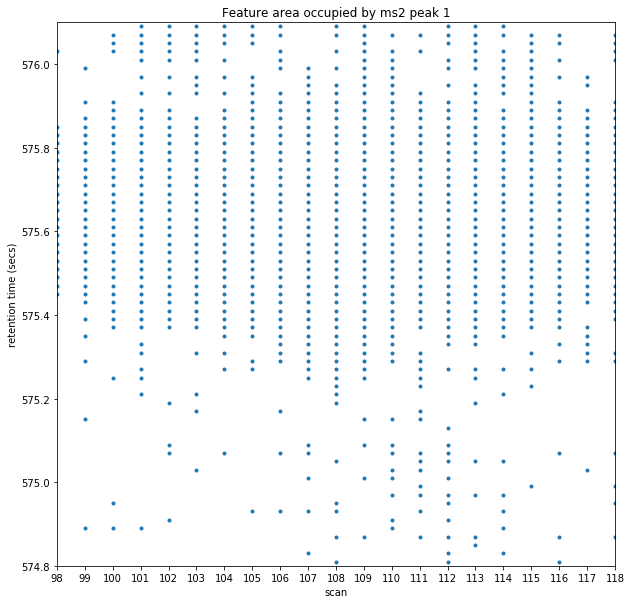

In [300]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.plot(peak_raw_points_df.scan, peak_raw_points_df.retention_time_secs, marker='o', linestyle='', ms=3)
ax.set_xlim([feature_df.loc[0].scan_lower, feature_df.loc[0].scan_upper])
ax.set_ylim([feature_df.loc[0].rt_secs_start, feature_df.loc[0].rt_secs_end])
plt.xlabel('scan')
plt.ylabel('retention time (secs)')
plt.xticks(range(int(feature_df.loc[0].scan_lower), int(feature_df.loc[0].scan_upper)+1))
plt.margins(0.06)
plt.title('Feature area occupied by ms2 peak {}'.format(ms2_peak_id))
plt.show()

In [301]:
max_cells = int(feature_df.loc[0].end_frame - feature_df.loc[0].start_frame) * frame_summing_offset * int(feature_df.loc[0].scan_upper - feature_df.loc[0].scan_lower)

In [302]:
max_cells

1300

In [303]:
float(number_of_cells_occupied_for_this_peak) / max_cells

0.9046153846153846